In [1]:
import dame_flame
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import heapq
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import LabelBinarizer

C:\Users\Neha\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
STAR_Students = pd.read_spss('STAR_Students.sav')

In [3]:
#math = math.rank(pct=True)*100

In [4]:
list(STAR_Students.columns)

['stdntid',
 'gender',
 'race',
 'birthmonth',
 'birthday',
 'birthyear',
 'FLAGSGK',
 'FLAGSG1',
 'FLAGSG2',
 'FLAGSG3',
 'flaggk',
 'flagg1',
 'flagg2',
 'flagg3',
 'flagg4',
 'flagg5',
 'flagg6',
 'flagg7',
 'flagg8',
 'flagprt4',
 'flagidn8',
 'flagprt8',
 'flagsatact',
 'flaghscourse',
 'flaghsgraduate',
 'gkclasstype',
 'g1classtype',
 'g2classtype',
 'g3classtype',
 'cmpstype',
 'cmpsdura',
 'yearsstar',
 'yearssmall',
 'gkschid',
 'gksurban',
 'gktchid',
 'gktgen',
 'gktrace',
 'gkthighdegree',
 'gktcareer',
 'gktyears',
 'gkclasssize',
 'gkfreelunch',
 'gkrepeat',
 'gkspeced',
 'gkspecin',
 'gkpresent',
 'gkabsent',
 'gktreadss',
 'gktmathss',
 'gktlistss',
 'gkwordskillss',
 'gkmotivraw',
 'gkselfconcraw',
 'g1schid',
 'g1surban',
 'g1tchid',
 'g1tgen',
 'g1trace',
 'g1thighdegree',
 'g1tcareer',
 'g1tyears',
 'g1classsize',
 'g1freelunch',
 'g1promote',
 'g1speced',
 'g1specin',
 'g1present',
 'g1absent',
 'g1treadss',
 'g1tmathss',
 'g1tlistss',
 'g1wordskillss',
 'g1readbs

In [5]:
'gkwordskillss' in STAR_Students.columns

True

In [6]:


"""Code to replicate Section 3.2 of dame-flame paper.

Note that this relies on the file Star_Students.sav. To download this file,
please see the original data on the Harvard Dataverse at this link:
https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/10766

Prints Figure 2 from dame-flame paper to a file with name cate-graph4.png

"""

# Data Cleaning Steps
'''df_trunc = STAR_Students.loc[:, STAR_Students.columns.intersection(
    ['gkclasstype', 'gender', 'race', 'gktrace', 'gkfreelunch', 
     'birthmonth', 'gksurban', 'gktgen', 'gktreadss', 'gkschid',
     'gkthighdegree', 'birthyear'])]
'''
    
df_trunc = STAR_Students.loc[:, STAR_Students.columns.intersection(
    ['gkclasstype', 'gender', 'race', 'gktrace', 'gkfreelunch', 
     'birthmonth', 'gksurban', 'gktgen', 'gktreadss', 'gkschid',
     'gkthighdegree', 'birthyear', 'gktmathss', 'gkwordskillss'])]

d = {"WHITE": 1, "BLACK": 0, "ASIAN": 1, "HISPANIC": 0, "OTHER": 0, 
     "NATIVE AMERICAN": 0}
df_trunc['race'] = df_trunc['race'].map(d)

d = {"NON-FREE LUNCH": 0, "FREE LUNCH": 1}
df_trunc['gkfreelunch'] = df_trunc['gkfreelunch'].map(d)

d = {"MALE": 1, "FEMALE": 0}
df_trunc['gender'] = df_trunc['gender'].map(d)
df_trunc['gktgen'] = df_trunc['gktgen'].map(d)

d = {"WHITE": 1, "BLACK": 0}
df_trunc['gktrace'] = df_trunc['gktrace'].map(d)

d = {"JANUARY": 0, "FEBRUARY": 1, "MARCH": 2, "APRIL": 3, "MAY": 4, 
     "JUNE": 5, "JULY": 6, "AUGUST": 7, "SEPTEMBER": 8, "OCTOBER": 9, 
     "NOVEMBER": 10, "DECEMBER": 11}
df_trunc['birthmonth'] = df_trunc['birthmonth'].map(d)

d = {1977: 0, 1978: 1, 1979: 2, 1980:3, 1981:4}
df_trunc['birthyear'] = df_trunc['birthyear'].map(d)

d = {"RURAL": 0, "URBAN":1, "SUBURBAN": 2, "INNER CITY": 3}
df_trunc['gksurban'] = df_trunc['gksurban'].map(d)

d = {"BACHELORS": 0, "MASTERS": 1, "MASTERS + ": 1, "SPECIALIST": 1}
df_trunc['gkthighdegree'] = df_trunc['gkthighdegree'].map(d)

d = {"SMALL CLASS": int(1), "REGULAR CLASS": int(0), 
     "REGULAR + AIDE CLASS": int(0)}
df_trunc['ksmall'] = df_trunc['gkclasstype'].map(d)

df_trunc = df_trunc.dropna().copy()

# Create age variable counting months
df_trunc['age'] = df_trunc['birthyear']*12 + df_trunc['birthmonth']
df_trunc = df_trunc.drop(columns=['birthmonth', 'birthyear', 
                                  'gkclasstype'])
# Bin age into deciles
df_trunc['age'] = pd.qcut(df_trunc['age'], q=10, labels=False)

df_trunc = df_trunc.rename(columns={"ksmall": "treated"}) ## NOTE TO SELF -- COME BACK TO WE SHOULDNT HAVE TO DO THIS

In [7]:
# Percentile the math and reading and then average them
# but do different percentiles for the small class size people and the large people.
df_trunc_untreated = df_trunc[df_trunc['treated'] == 0]
df_trunc_untreated['gktreadss'] = df_trunc_untreated['gktreadss'].rank(pct=True)*100
df_trunc_untreated['gktmathss'] = df_trunc_untreated['gktmathss'].rank(pct=True)*100
df_trunc_untreated['gkwordskillss'] = df_trunc_untreated['gkwordskillss'].rank(pct=True)*100
df_trunc_untreated['outcome'] = df_trunc_untreated[['gktreadss', 'gktmathss', 'gkwordskillss']].mean(axis=1)

df_trunc_treated = df_trunc[df_trunc['treated'] == 1]
df_trunc_treated['gktreadss'] = df_trunc_treated['gktreadss'].rank(pct=True)*100
df_trunc_treated['gktmathss'] = df_trunc_treated['gktmathss'].rank(pct=True)*100
df_trunc_treated['gkwordskillss'] = df_trunc_treated['gkwordskillss'].rank(pct=True)*100
df_trunc_treated['outcome'] = df_trunc_treated[['gktreadss', 'gktmathss', 'gkwordskillss']].mean(axis=1)

C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [8]:
df = pd.concat([df_trunc_treated, df_trunc_untreated])
df = df.drop(columns=['gktreadss', 'gktmathss', 'gkwordskillss'])

In [9]:
df.columns

Index(['gender', 'race', 'gkschid', 'gksurban', 'gktgen', 'gktrace',
       'gkthighdegree', 'gkfreelunch', 'treated', 'age', 'outcome'],
      dtype='object')

In [10]:
# Do the matching

ates = []
var_ates = []
models = []
random_seeds = [1234, 2346, 3467, 4678]
for i in range(4):
    matching_df, holdout_df = train_test_split(df, test_size=0.2, random_state=random_seeds[i])
    model_dame = dame_flame.matching.DAME(
        repeats=False, verbose=0, adaptive_weights='decisiontree', 
        missing_holdout_replace=1, missing_data_replace=1, 
        early_stop_pe=True)
    model_dame.fit(holdout_data=holdout_df)
    result_dame = model_dame.predict(matching_df)
    ates.append(dame_flame.utils.post_processing.ATE(model_dame))
    models.append(model_dame)



2935 units matched. We finished with no more treated units to match
2828 units matched. We finished with no more treated units to match
2865 units matched. We finished with no more treated units to match
2938 units matched. We finished with no more treated units to match


In [11]:
for i in range(len(models)):
    ate, var = dame_flame.utils.post_processing.var_ATE(matching_object=models[i])
    print("ATE of trial", i, ":", ate,". Variance: ", var)

treated_col treated
ATE of trial 0 : 0.6277951159791607 . Variance:  0.9050922341376137
treated_col treated
ATE of trial 1 : 0.04390259064719584 . Variance:  0.9072358076502579
treated_col treated
ATE of trial 2 : 0.760840106552819 . Variance:  0.8883632377676736
treated_col treated
ATE of trial 3 : 0.748411150193757 . Variance:  0.918455473008755


C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

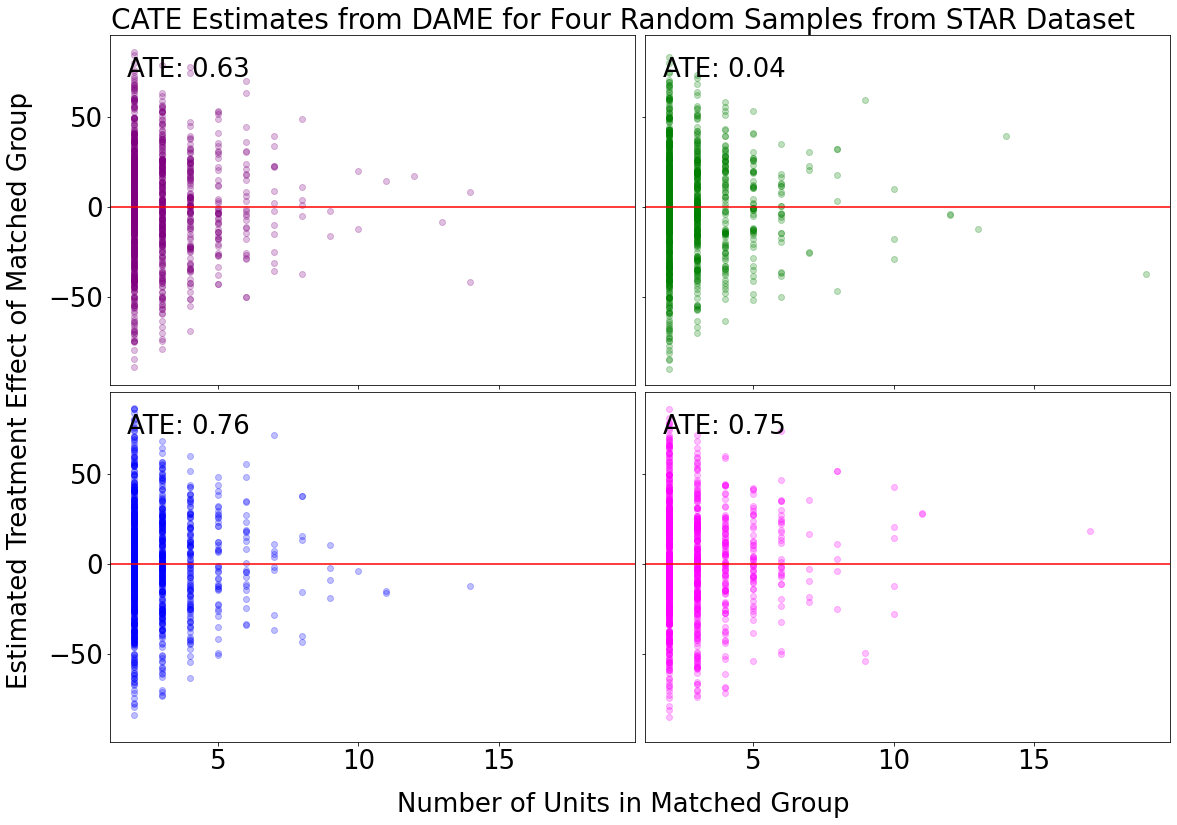

In [12]:
# Create the plot
match_dfs = []
for i in models:
    match_dfs.append(i.input_data)

for i in range(4):
    colname = 'cates'
    match_dfs[i][colname] = dame_flame.utils.post_processing.CATE(
        models[i], match_dfs[i].index)

dame_len_groups = []
dame_cate_of_groups = []

for i in range(4):

    model_dame = models[i]
    groups = list(range(len(model_dame.units_per_group)))

    dame_cate_of_group = []
    dame_len_group = []
    dame_len_treated = []
    maxcate = 0.0
    maxgroupnum = 0
    index = 0

    flame_cate_of_group = []
    flame_len_group = []
    large_groups = []
    for group in model_dame.units_per_group:
        dame_cate_of_group.append(dame_flame.utils.post_processing.CATE(
            model_dame, group[0]))
        dame_len_group.append(len(group))

        # find len of just treated units
        df_mmg = df.loc[group]
        treated = df_mmg.loc[df_mmg["treated"] == 1]

    dame_len_groups.append(dame_len_group)
    dame_cate_of_groups.append(dame_cate_of_group)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (19,13), 
                                             sharex=True, sharey=True)
fig.text(0.5, 0.05, 'Number of Units in Matched Group', ha='center', 
         fontsize=26)
fig.text(0.05, 0.5, 'Estimated Treatment Effect of Matched Group', 
         va='center', rotation='vertical', fontsize=26)
fig.suptitle("CATE Estimates from DAME for Four Random Samples from STAR Dataset", fontsize=28, y=0.91)
ax1.axhline(y=0.0, color='r', linestyle='-')
ax2.axhline(y=0.0, color='r', linestyle='-')
ax3.axhline(y=0.0, color='r', linestyle='-')
ax4.axhline(y=0.0, color='r', linestyle='-')

ax1.tick_params(labelsize=26)
ax2.tick_params(labelsize=26)
ax3.tick_params(labelsize=26)
ax4.tick_params(labelsize=26)

ax1.scatter(dame_len_groups[0], dame_cate_of_groups[0], color="purple", 
            alpha = 0.25)
ax1.text(0.15, 0.9,'ATE: '+str(round(ates[0],2)), ha='center', va='center',
         transform=ax1.transAxes, fontsize=26)

ax2.scatter(dame_len_groups[1], dame_cate_of_groups[1], color="green", 
            alpha = 0.25)
ax2.text(0.15, 0.9,'ATE: '+str(round(ates[1],2)), ha='center', va='center',
         transform=ax2.transAxes, fontsize=26)

ax3.scatter(dame_len_groups[2], dame_cate_of_groups[2], color="blue", 
            alpha = 0.25)
ax3.text(0.15, 0.9,'ATE: '+str(round(ates[2],2)), ha='center', va='center',
         transform=ax3.transAxes, fontsize=26)

ax4.scatter(dame_len_groups[3], dame_cate_of_groups[3], color="magenta",
            alpha = 0.25)
ax4.text(0.15, 0.9,'ATE: '+str(round(ates[3],2)), ha='center', va='center',
         transform=ax4.transAxes, fontsize=26)

plt.subplots_adjust(wspace=.02, hspace=.02)
## plt.savefig('cate-graph4.png', dpi = 200)

In [13]:
list_star_covars = []
for modelid in range(len(models)):

    # Pull out the groups with 10 or more units in the matched group
    model = models[modelid]
    large_groups = []
    for group in model.units_per_group:
        if len(group) >= 12.5:
            large_groups.append(group)

    covariates = set(models[modelid].input_data.columns) - set(['gktreadss', 'treated', 'cates'])
    # Which covars did the large group match on?
    star_covars = dict()
    for group in large_groups:
        group_star_covars = []
        matched_df = models[modelid].df_units_and_covars_matched.loc[group]
        for covar in covariates:
            if '*' in matched_df[covar].values:
                group_star_covars.append(covar)
        cate_of_group = models[modelid].input_data.loc[group[0], 'cates']
        star_covars[cate_of_group] = group_star_covars
        
    list_star_covars.append(star_covars)

KeyError: 'outcome'

In [ ]:
list_star_covars

In [ ]:
## Check the matched group with the most units in each trial -- also which covariates did they use and which units in their MMG?

In [ ]:
## Run DAME and FLAME and show why we chose DAME for this dataset. What happens if we run FLAME?
flame_models = []
random_seeds = [1234, 2346, 3467, 4678]
for i in range(4):
    matching_df, holdout_df = train_test_split(df, test_size=0.2, random_state=random_seeds[i])
    model_flame = dame_flame.matching.FLAME(
        repeats=False, verbose=3, adaptive_weights='decisiontree', 
        missing_holdout_replace=1, missing_data_replace=1, 
        early_stop_pe=True)
    model_flame.fit(holdout_data=holdout_df, 
                   outcome_column_name='gktreadss')
    result_flame = model_flame.predict(matching_df)
    flame_models.append(model_flame)


In [ ]:
# whats the var of the ates?
for model in fmodels:
    print(dame_flame.utils.post_processing.var_ATE(matching_object=model))